In [34]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [35]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

class GradCAM1D:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, x, meta, class_idx=None):
        self.model.zero_grad()
        out = self.model(x, meta)
        if class_idx is None:
            class_idx = out.argmax(dim=1).item()
        score = out[0, class_idx]
        score.backward()
        grads = self.gradients.mean(dim=2, keepdim=True)
        cam = F.relu((grads * self.activations).sum(dim=1)).squeeze()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        return cam.cpu().numpy(), class_idx


In [36]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os
import os, glob, random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from collections import defaultdict
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import matplotlib.pyplot as plt

In [37]:
class CNN1DGRU(nn.Module):
    def __init__(self, in_channels, meta_dim=3, n_classes=5, hidden=128, layers=1, bidirectional=True):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(64, 128, 3, padding=1)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(2)

        self.conv3 = nn.Conv1d(128, 256, 3, padding=1)
        self.bn3 = nn.BatchNorm1d(256)
        self.pool3 = nn.MaxPool1d(2)

        self.gru = nn.GRU(input_size=256, hidden_size=hidden, num_layers=layers,
                          bidirectional=bidirectional, batch_first=False)
        out_dim = hidden * (2 if bidirectional else 1)
        self.fc = nn.Sequential(
            nn.Linear(out_dim + meta_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, n_classes)
        )

    def forward(self, x, meta):
        x = F.relu(self.bn1(self.conv1(x))); x = self.pool1(x)
        x = F.relu(self.bn2(self.conv2(x))); x = self.pool2(x)
        x = F.relu(self.bn3(self.conv3(x))); x = self.pool3(x)

        
        
        x = x.permute(2,0,1)
        out, _ = self.gru(x)
        last = out[-1]  
        
        cat = torch.cat([last, meta], dim=1)
        return self.fc(cat)

In [ ]:
meta_path = "/kaggle/input/meta-data/Metadata.csv"
meta_df = pd.read_csv(meta_path)


meta_df["Gender"] = meta_df["Gender"].map({"M": 0, "F": 1})


meta_df = meta_df[["SubjectID", "Age", "Gender", "BMI", "Diagnosis"]]


def get_meta_for_patient(file_path, meta_df):
    import os

    
    patient_id = os.path.normpath(file_path).split(os.sep)[-3]

 
    if meta_df["SubjectID"].dtype != object:
        meta_df["SubjectID"] = meta_df["SubjectID"].astype(str)
    meta_df["SubjectID"] = meta_df["SubjectID"].str.zfill(2)

   
    rows = meta_df.loc[meta_df["SubjectID"] == patient_id]
    if len(rows) == 0:
        raise ValueError(f"No metadata found for patient_id = {patient_id}")
    
    row = rows.iloc[0]

    meta = torch.tensor(
        [[row["Age"], row["Gender"], row["BMI"]]],
        dtype=torch.float32
    )

    label = row["Diagnosis"]

    return meta, row, label


model = CNN1DGRU(in_channels=40, meta_dim=3, n_classes=5)
model.load_state_dict(torch.load("/kaggle/input/beat-model/best_model.pth", map_location="cpu"))
model.eval()

CNN1DGRU(
  (conv1): Conv1d(40, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (gru): GRU(256, 128, bidirectional=True)
  (fc): Sequential(
    (0): Linear(in_features=259, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=5, bias=True)
  )
)

In [61]:
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import shap
from scipy.ndimage import label
import openai 
DURATION_SEC = 20.0
TOP_K_REGIONS = 3
THRESHOLD_PCT = 0.45  

In [62]:
def cam_to_time_ranges(cam, top_k=3, threshold_pct=0.5):
    n_frames = cam.shape[0]
    sec_per_frame = DURATION_SEC / n_frames
    window = 5
    cam_smooth = np.convolve(cam, np.ones(window)/window, mode='same')
    cam_norm = (cam_smooth - cam_smooth.min()) / (cam_smooth.max() - cam_smooth.min() + 1e-8)
    thr = threshold_pct * cam_norm.max()
    mask = cam_norm >= thr
    labeled, n_labels = label(mask)
    regions = []
    for lbl in range(1, n_labels+1):
        idxs = np.where(labeled == lbl)[0]
        start_frame, end_frame = idxs[0], idxs[-1]
        avg_score = cam_norm[idxs].mean()
        regions.append((start_frame*sec_per_frame, (end_frame+1)*sec_per_frame, avg_score))
    if len(regions) == 0:
        peak_idxs = np.argsort(cam_norm)[-top_k:][::-1]
        for idx in peak_idxs:
            regions.append((max(0, (idx-2))*sec_per_frame, min(n_frames, idx+3)*sec_per_frame, cam_norm[idx]))
    regions_sorted = sorted(regions, key=lambda x: x[2], reverse=True)[:top_k]
    return regions_sorted


In [63]:
def shap_to_text(shap_values_for_class, feature_names=['Age','Gender','BMI'], top_n=3):
    out = []
    for i, fname in enumerate(feature_names):
        val = float(shap_values_for_class[i])
        direction = "increased" if val > 0 else "decreased"
        magnitude = abs(val)
        out.append(f"{fname}: {direction} model probability by {magnitude:.3f}")
    return sorted(out, key=lambda s: -float(s.split()[-1]))[:top_n]




def build_explanation(patient_id, predicted_class, softmax_prob, cam, shap_values, meta_row, n_files):
    regions = cam_to_time_ranges(cam, TOP_K_REGIONS, THRESHOLD_PCT)
    meta_text = shap_to_text(shap_values, ['Age','Gender','BMI'])
    return {
        "patient_id": patient_id,
        "predicted_class": predicted_class,
        "probability": round(float(softmax_prob), 3),
        "meta": {
            "Age": float(meta_row["Age"]),
            "Gender": int(meta_row["Gender"]),
            "BMI": float(meta_row["BMI"])
        },
        "meta_influence": meta_text,
        "top_time_regions_sec": [
            {"start": round(s,2), "end": round(e,2), "score": round(scr,2)} 
            for s,e,scr in regions
        ],
        "n_samples_used": n_files,
        "notes": "CAM averaged across all patient's samples"
    }



def aggregate_cam_for_patient(patient_folder, model, cam_explainer, meta_df):
    cams = []
    patient_id = os.path.basename(patient_folder)
    files = []
    for root, _, fnames in os.walk(patient_folder):
        for f in fnames:
            if f.endswith(".npy"):
                fpath = os.path.join(root, f)
                x = torch.tensor(np.load(fpath), dtype=torch.float32).unsqueeze(0)
                meta, _ = get_meta_for_patient(fpath, meta_df)
                cam, _ = cam_explainer.generate(x, meta)
                cams.append(cam)
                files.append(fpath)
    cam_mean = np.mean(cams, axis=0)
    return cam_mean, files, patient_id


In [ ]:
file_path = "/kaggle/input/data-aug-20-secs/augmented_data/04/DIAP/04_05_AAL.npy"
meta_df = pd.read_csv("/kaggle/input/meta-data/Metadata.csv")
meta_df["Gender"] = meta_df["Gender"].map({"M":0,"F":1})
meta_df.drop(['Height', 'Weight', 'Place'], axis=1, inplace=True)


meta, meta_row, true_label = get_meta_for_patient(file_path, meta_df)

x = torch.tensor(np.load(file_path), dtype=torch.float32).unsqueeze(0)
with torch.no_grad():
    logits = model(x, meta)
    probs = F.softmax(logits, dim=1)
pred_idx = probs.argmax(dim=1).item()
pred_class = ["COPD","ILD","Asthma","Healthy","Infection"][pred_idx]
softmax_prob = probs[0, pred_idx].item()
cam_explainer = GradCAM1D(model, model.conv3)
cam, _ = cam_explainer.generate(x, meta)

# SHAP
def predict_fn(meta_np):
    meta_t = torch.tensor(meta_np, dtype=torch.float32)
    x_t = x.repeat(len(meta_t), 1, 1)
    with torch.no_grad():
        out = model(x_t, meta_t)
        return F.softmax(out, dim=1).numpy()

background = np.array([[40,0,22],[55,1,27],[30,0,19]])
patient_meta = meta.numpy()
explainer = shap.KernelExplainer(predict_fn, background)
shap_values_all = explainer.shap_values(patient_meta)
shap_values_for_class = shap_values_all[pred_idx][0]

# JSON
'''explanation = build_explanation(
    patient_id="01",
    predicted_class=pred_class,
    softmax_prob=softmax_prob,
    cam=cam,
    shap_values=shap_values_for_class,
    meta_row=meta_row,
    n_files=1
)

print("Explanation JSON ready ✅")
print(explanation)'''

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


  0%|          | 0/1 [00:00<?, ?it/s]

'explanation = build_explanation(\n    patient_id="01",\n    predicted_class=pred_class,\n    softmax_prob=softmax_prob,\n    cam=cam,\n    shap_values=shap_values_for_class,\n    meta_row=meta_row,\n    n_files=1\n)\n\nprint("Explanation JSON ready ✅")\nprint(explanation)'

In [65]:
print(meta_df.columns)


Index(['SubjectID', 'Age', 'Gender', 'BMI', 'Diagnosis'], dtype='object')


Predicted class: Infection
Metadata: {'Age': 67, 'Gender': 1, 'BMI': 28.578, 'Diagnosis': 'Infection'}


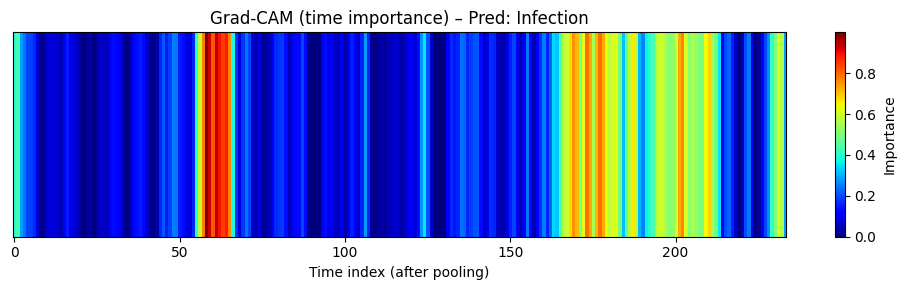

In [ ]:
file_path="/kaggle/input/data-aug-20-secs/augmented_data/60/DIAP/60_02_PAR_aug158.npy"

spec = np.load(file_path)                   
x = torch.tensor(spec, dtype=torch.float32).unsqueeze(0)  
meta, meta_row ,label= get_meta_for_patient(file_path, meta_df)

classes = ["COPD","ILD","Asthma","Healthy","Infection"]

cam_explainer = GradCAM1D(model, model.conv3)
cam, pred_idx = cam_explainer.generate(x, meta)
pred_class = classes[pred_idx]

print("Predicted class:", pred_class)
print("Metadata:", meta_row[["Age", "Gender", "BMI", "Diagnosis"]].to_dict())

plt.figure(figsize=(10, 3))
plt.imshow(cam[np.newaxis, :], aspect="auto", cmap="jet")
plt.colorbar(label="Importance")
plt.title(f"Grad-CAM (time importance) – Pred: {pred_class}")
plt.xlabel("Time index (after pooling)")
plt.yticks([])
plt.tight_layout()
plt.show()